# ResNet论文的复现和解析

## 简述

ResNet (Residual Networks) 是由何凯明等人在 2015 年提出的深度残差网络，解决了深层神经网络训练困难的问题，在 ImageNet 比赛中取得了突破性成果。
本文将一步步解析并复现 ResNet 的核心结构。

## 1.环境配置

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 查看是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cpu


## 2.ResNet核心思想逻辑分析

ResNet 的核心创新是残差块 (Residual Block)，解决了深层网络中的梯度消失和性能退化问题。  

传统网络: H(x)=F(x)  

ResNet 残差网络：\(H(x) = F(x) + x  

其中F(x)是残差函数,表示需要学习的残差部分,x为输入的恒等映射  

当一个网络的深度很深时,让F(x) = 0比学习一个复杂的H(x)更加容易,这样可以使网络更加容易得到优化  



## 3.残差块(Residual Block)实现

根据论文,ResNet的残差有两种形式:  

基本块(Basic Block): 用于ResNet-18和ResNet-34  

瓶颈块(Bottle Neck): 用于更加深的网络(ResNet-50,101,152)  

In [2]:
#基本残差块
class BasicBlock(nn.Module):
    expansion = 1  # 输出通道数扩展倍数
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 第一个卷积层
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, 
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 第二个卷积层
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 用于调整输入x的维度，使其能与F(x)相加
    
    def forward(self, x):
        identity = x  # 保存输入，用于后续的恒等映射
        
        # 第一个卷积操作
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 第二个卷积操作
        out = self.conv2(out)
        out = self.bn2(out)
        
        # 如果需要下采样（维度不匹配时）
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # 残差连接：输出 + 恒等映射
        out += identity
        out = self.relu(out)
        
        return out

In [3]:
#瓶颈残差块
class Bottleneck(nn.Module):
    expansion = 4  # 输出通道数扩展倍数
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1卷积，减少通道数
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3卷积，主要的特征提取
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1卷积，恢复并扩展通道数
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        # 第一个1x1卷积
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 3x3卷积
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 第二个1x1卷积
        out = self.conv3(out)
        out = self.bn3(out)
        
        # 下采样（如果需要）
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # 残差连接
        out += identity
        out = self.relu(out)
        
        return out

## 4.完整的ResNet模型构建

In [4]:
# 初始化卷积层 + 池化层
# 多个残差块组成的阶段
# 全局平均池化 + 全连接层
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64  # 初始输入通道数
        
        # 初始卷积层
        self.conv1 = nn.Conv2d(
            3, self.in_channels, kernel_size=7, stride=2, 
            padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # 初始池化层
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 残差块阶段
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # 全局平均池化
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 全连接层
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """构建由多个残差块组成的层"""
        downsample = None
        
        # 如果步长不为1或输入输出通道数不匹配，需要下采样
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, out_channels * block.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        # 添加第一个残差块（可能需要下采样）
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        # 添加剩余的残差块
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # 初始卷积和池化
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 残差块阶段
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 全局平均池化和全连接层
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

## 5.定义不同深度的ResNet模型

In [5]:
def resnet18(num_classes=1000):
    """构建ResNet-18模型"""
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    """构建ResNet-34模型"""
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    """构建ResNet-50模型"""
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    """构建ResNet-101模型"""
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    """构建ResNet-152模型"""
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

## 6.模型测试与参数估计

In [6]:
def count_parameters(model):
    """统计模型参数数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 测试ResNet-18
model_res18 = resnet18().to(device)
print(f"ResNet-18 参数数量: {count_parameters(model_res18):,}")

# 测试ResNet-50
model_res50 = resnet50().to(device)
print(f"ResNet-50 参数数量: {count_parameters(model_res50):,}")

# 测试前向传播
x = torch.randn(2, 3, 224, 224).to(device)  # 模拟2张224x224的RGB图像
output_res18 = model_res18(x)
output_res50 = model_res50(x)
print(f"ResNet-18 输出形状: {output_res18.shape}")
print(f"ResNet-50 输出形状: {output_res50.shape}")

ResNet-18 参数数量: 11,689,512
ResNet-50 参数数量: 25,557,032
ResNet-18 输出形状: torch.Size([2, 1000])
ResNet-50 输出形状: torch.Size([2, 1000])


## 7.在CIFAR-10数据集上训练ResNet


为了验证模型效果，我们在 CIFAR-10 数据集上进行简单训练。由于我电脑不行,计算资源限制，因此我使用较小的 ResNet-18 模型，并调整输入尺寸

In [7]:
# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
trainloader = DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [05:24<00:00, 526kB/s]  


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
#调整 ResNet-18 以适应 CIFAR-10 的输入尺寸 (32x32)
class ResNetCIFAR(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetCIFAR, self).__init__()
        self.in_channels = 64
        
        # 对于CIFAR-10，使用3x3卷积替代7x7卷积，取消初始的maxpool
        self.conv1 = nn.Conv2d(
            3, self.in_channels, kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # 残差块阶段
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # 全局平均池化
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 全连接层
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, out_channels * block.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def resnet18_cifar(num_classes=10):
    return ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes)

In [9]:
#训练函数定义
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=20):
    """训练模型并返回训练/测试准确率和损失"""
    model.to(device)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练阶段
        model.train()
        train_running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播、计算损失、反向传播、参数更新
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # 统计训练数据
            train_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 每100个批次打印一次信息
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1}] loss: {train_running_loss / 100:.3f}')
                train_running_loss = 0.0
        
        # 计算训练集准确率和平均损失
        train_acc = 100 * correct / total
        train_loss = train_running_loss / len(trainloader)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        # 测试阶段
        model.eval()
        test_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # 不计算梯度，节省内存
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # 计算测试集准确率和平均损失
        test_acc = 100 * correct / total
        test_loss = test_running_loss / len(testloader)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} - 时间: {epoch_time:.2f}s')
        print(f'训练准确率: {train_acc:.2f}%，损失: {train_loss:.4f}')
        print(f'测试准确率: {test_acc:.2f}%，损失: {test_loss:.4f}\n')
    
    print('训练完成')
    return train_losses, train_accs, test_losses, test_accs

开始训练

In [10]:
# 初始化模型、损失函数和优化器
model = resnet18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)

# 训练模型（这里我们只训练少量epoch作为演示）
num_epochs = 10
train_losses, train_accs, test_losses, test_accs = train_model(
    model, trainloader, testloader, criterion, optimizer, num_epochs
)

[1, 100] loss: 2.629
[1, 200] loss: 1.894
[1, 300] loss: 1.752
Epoch 1 - 时间: 618.22s
训练准确率: 29.73%，损失: 0.3794
测试准确率: 39.02%，损失: 1.6357

[2, 100] loss: 1.566
[2, 200] loss: 1.460
[2, 300] loss: 1.395
Epoch 2 - 时间: 632.20s
训练准确率: 47.38%，损失: 0.2997
测试准确率: 48.49%，损失: 1.4638

[3, 100] loss: 1.219
[3, 200] loss: 1.115
[3, 300] loss: 1.077
Epoch 3 - 时间: 621.73s
训练准确率: 60.26%，损失: 0.2369
测试准确率: 64.32%，损失: 1.0117

[4, 100] loss: 0.951
[4, 200] loss: 0.915
[4, 300] loss: 0.895
Epoch 4 - 时间: 615.95s
训练准确率: 68.11%，损失: 0.1983
测试准确率: 68.78%，损失: 0.8819

[5, 100] loss: 0.795
[5, 200] loss: 0.758
[5, 300] loss: 0.736
Epoch 5 - 时间: 624.70s
训练准确率: 74.03%，损失: 0.1597
测试准确率: 72.87%，损失: 0.8120

[6, 100] loss: 0.662
[6, 200] loss: 0.643
[6, 300] loss: 0.641
Epoch 6 - 时间: 625.01s
训练准确率: 77.91%，损失: 0.1480
测试准确率: 70.02%，损失: 0.9278

[7, 100] loss: 0.596
[7, 200] loss: 0.595
[7, 300] loss: 0.587
Epoch 7 - 时间: 624.36s
训练准确率: 79.70%，损失: 0.1347
测试准确率: 72.75%，损失: 0.8631

[8, 100] loss: 0.534
[8, 200] loss: 0.555
[8, 30

## 8.训练结果可视化

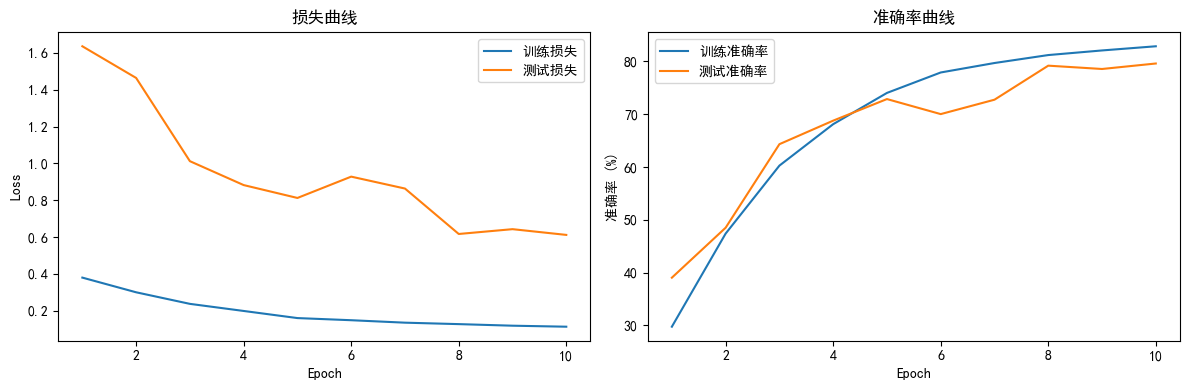

In [12]:
# 绘制损失曲线
plt.rcParams['font.family'] = ['SimHei'] #设置中文字体
plt.rcParams['axes.unicode_minus'] = False #设置负号显示
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='训练损失')
plt.plot(range(1, num_epochs+1), test_losses, label='测试损失')
plt.title('损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='训练准确率')
plt.plot(range(1, num_epochs+1), test_accs, label='测试准确率')
plt.title('准确率曲线')
plt.xlabel('Epoch')
plt.ylabel('准确率 (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 9.ResNet论文的核心贡献

1.残差学习：提出了残差块结构，通过学习残差函数\(F(x) = H(x) - x，使深层网络更容易训练。  

2.解决退化问题：随着网络深度增加，传统网络会出现性能退化（准确率饱和后迅速下降），ResNet 通过残差连接有效解决了这一问题。  

3.恒等映射 shortcut：论文比较了不同的 shortcut 连接方式，发现简单的恒等映射（当维度匹配时）效果最好，计算量也最小。  

4.深度可扩展性：ResNet 可以轻松扩展到非常深的网络（如 152 层），且性能随深度增加而提升。  

5.批归一化：在每个卷积层后使用批归一化，加速训练并减少过拟合。  
